<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/observation_tools/promptfoo/promptfoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  LLM Evaluations with Promptfoo and UpTrain 

**UpTrain** [ [website](https://uptrain.ai/) | [github](https://github.com/uptrain-ai/uptrain) | [docs](https://docs.uptrain.ai/getting-started/introduction) ] 

UpTrain is an open-source tool to evaluate LLM generated responses. 
Using UpTrain you can:
1. Evaluate LLM generated responses over 20+ preconfigured checks (covering language, code, embedding use cases)
2. Perform root cause analyses on instances of failure cases

and a lot more...


**Promptfoo** [ [website](https://promptfoo.dev/) | [github](https://github.com/promptfoo/promptfoo) | [docs](https://promptfoo.dev/docs/intro) ] 
Promptfoo is an LLM observability tool that helps observe your LLM experiments. 

Using Promptfoo you can:
1. compare prompts and model outputs side-by-side
2. integrate the library into your existing test/CI workflow.

and a lot more

## Overview

Using this notebook we will be experimenting over a set of 3 different prompts. These prompts are used to answer user queries using information based on a context (similar to RAG). Further, we will be using 2 different models (GPT 3.5 Turbo and GPT 4) to generate responses.

We will be using Promptfoo's dashboard to evaluate these responses over following UpTrain metrics:

1. [Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance): Evaluates how relevant the retrieved context is to the question specified.

2. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

3. [Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness): Evaluates whether the response has answered all the aspects of the question specified

4. [Response Relevance](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-relevance): Evaluates how relevant the generated response was to the question specified.

## Prerequisites
You need Node 16 or newer to use Promptfoo.

Please check if you have npx installed using this command in your terminal: `npx -v`

If not, have a look at this [documentation](https://www.npmjs.com/package/npx) 

In [1]:
!pip install uptrain

## How to do it?

Import `Evals` and `EvalPromptfoo` classes from uptrain 

In [2]:
from uptrain import Evals, EvalPromptfoo

Define your dataset

In [3]:
data = [
    {
      "question" : "Which is the most popular global sport?",
      "context" : "Football is undoubtedly on of the most popular sport with major events like the FIFA World Cup and sports personalities like Ronaldo and Messi, drawing a followership of more than 4 billion people.",
    },
    {
      "question" : "Where was basketball first played?",
      "context" : "Basketball, a dynamic sport, involves shooting, dribbling, and teamwork. It requires a ball and a hoop, typically played indoors or outdoors. The origin of basketball dates to the late 19th century, growing from a simple game into a worldwide phenomenon.",
    },
    {
      "question" : "What all do I need to play golf?",
      "context" : "Golf, a popular sport, demands equipment such as clubs, balls, tees, and appropriate attire. Access to a golf course or driving range is essential. Golf has a rich history traces back centuries, evolving into a game enjoyed globally."
    },
    {
      "question" : "How can i learn to play hockey?", 
      "context" : "Hockey has a rich history, originating in Canada in the 19th century, and has since become popular worldwide. Many local rinks offer learn-to-play programs for beginners."
    },
    {
      "question" : "What are the basic rules of badminton?",
      "context" : "Badminton, a racket sport, is played with a shuttlecock. It include serving diagonally, scoring points by landing the shuttlecock within the cour, and winning a match by scoring 21 points (or 15 in doubles). It is played indoors on a rectangular court divided by a net. The sport originated in ancient civilizations and gained popularity globally in the 19th century."
    }
]

Define your prompts 

In [4]:

prompts = """
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
Answer:
---
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
The answer should be short and crisp, not more than 20 words.
Answer:
---
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
The answer should be decriptive and you should not add any facts outside the retrieved document.
Answer:
"""

Define the models you want to use to generate results

In [5]:
providers = ['openai:chat:gpt-3.5-turbo-0613', 'openai:chat:gpt-4']

Define the list of Uptrain evaluations and assign them weights

For example we will be using the following 4 metrics and the weight of Response Relavance is 0.3 on a scale of 0 to 1

In [6]:
evals_list = [Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_COMPLETENESS, Evals.RESPONSE_RELEVANCE, Evals.FACTUAL_ACCURACY]
evals_weight = [0.05, 0.15, 0.3, 0.5] 

Define threshold

The threshold you need in your final scores (which is the weighted mean of UpTrain metrics defined in previous step)

In [7]:
threshold = 0.7

Perform evaluations using `EvalPromptfoo` method in Uptrain

Install promptfoo: you need to do this only for the first time

In [ ]:
promptfoo_client = EvalPromptfoo()
promptfoo_client.install()

In [8]:
promptfoo_client = EvalPromptfoo()

r = promptfoo_client.evaluate(
    evals_list=evals_list, 
    evals_weight=evals_weight, 
    input_data=data, 
    threshold=threshold, 
    prompts=prompts, 
    providers=providers, 
    eval_model='gpt-3.5-turbo-1106'    # The LLM you want UpTrain to use for evals 
)

(node:53401) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)



┌───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ context       │ question      │ [openai:gpt-3 │ [openai:gpt-4 │ [openai:gpt-3 │ [openai:gpt-4 │ [openai:gpt-3 │ [openai:gpt-4 │
│               │               │ .5-turbo-0613 │ ] Answer the  │ .5-turbo-0613 │ ] Answer the  │ .5-turbo-0613 │ ] Answer the  │
│               │               │ ] Answer the  │ following use │ ] Answer the  │ following use │ ] Answer the  │ following use │
│               │               │ following use │ r query using │ following use │ r query using │ following use │ r query using │
│               │               │ r query using │  the retrieve │ r query using │  the retrieve │ r query using │  the retrieve │
│               │               │  the retrieve │ d context:    │  the retrieve │ d context:    │  the retrieve │ d context:    │
│               │               │ d context:    │ {{question}}  │ d context:    │ {{quest

2024-03-16 13:08:49.596 | SUCCESS  | uptrain.integrations.promptfoo:evaluate:82 - Evaluations successfully generated
2024-03-16 13:08:49.604 | SUCCESS  | uptrain.integrations.promptfoo:evaluate:83 - Saved results to file: results_03_16_2024-13:06:20.csv


Done.


(node:56218) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)


Server running at http://localhost:15490 and monitoring for new evals.
Press Ctrl+C to stop the server


You will be redirected to your web browser with these results

## View the Output in Web Browser

You can view these results on your Web Browser

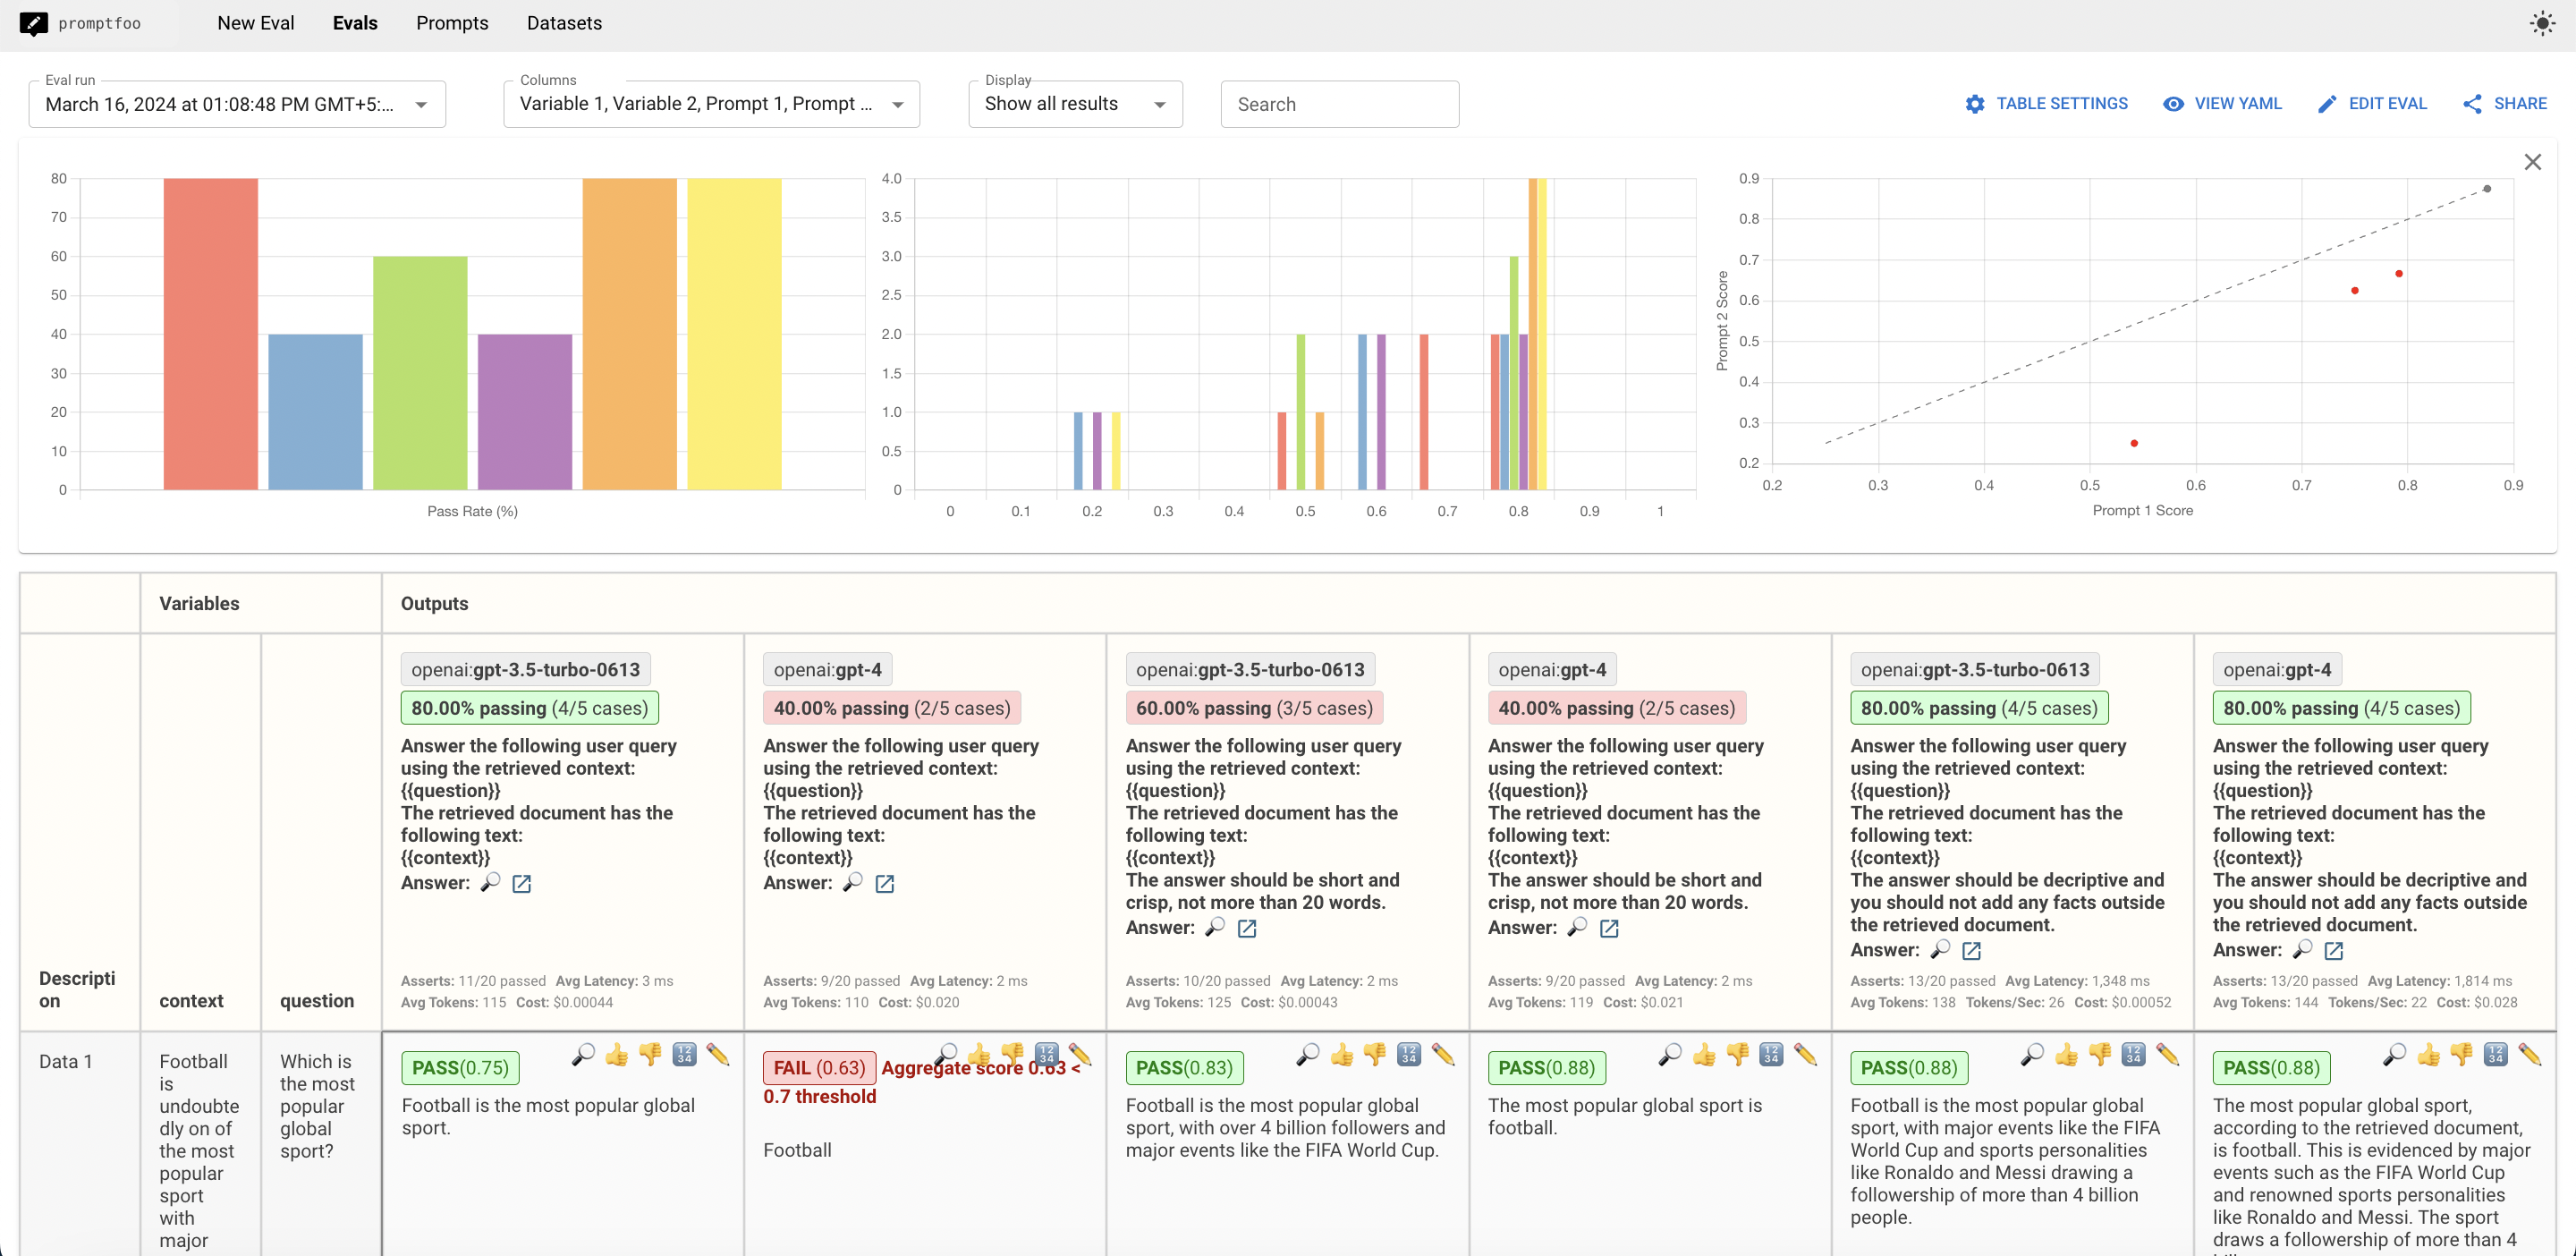